In [14]:
# https://keras.io/examples/vision/grad_cam/#setup
# https://dmitry.ai/t/topic/50/2
# Check Lambda Cloud

In [15]:
import os

# os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import decode_predictions
import numpy as np
import seaborn as sns
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import load_model
import tensorflow.keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Flatten
from tensorflow.keras import regularizers
from IPython.display import Image

import warnings 
warnings.filterwarnings('ignore')

In [16]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.17.0
Num GPUs Available:  1


In [17]:
img_path = r'test_img.jpeg'

In [ ]:
model = tf.keras.saving.load_model()

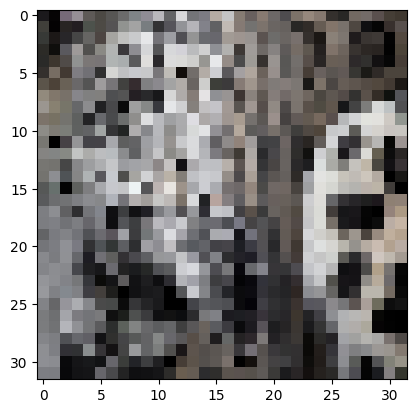

In [19]:
# Load img
img = image.load_img(img_path, target_size=(32, 32))
plt.imshow(img)

In [20]:
img = image.img_to_array(img)
img = preprocess_input(img, data_format=None)
img = img/255.0

img = np.expand_dims(img, axis=0)
img.shape, type(img)

((1, 32, 32, 3), numpy.ndarray)

In [21]:
img_pred = VGG16_model.predict(img)
print(img_pred)
print('FAKE') if img_pred.argmax() == 0 else print('REAL')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
[[0.99601007]]
FAKE


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

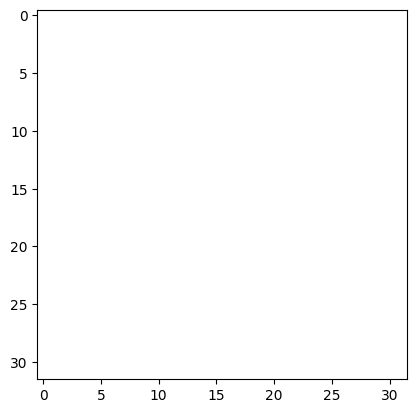

In [22]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions


    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)  
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # # This is a vector where each entry is the mean intensity of the gradient
    # # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# VGG
last_conv_layer_name = 'block1_conv2'
heatmap = make_gradcam_heatmap(img, VGG16_base_model, last_conv_layer_name, pred_index=0)


plt.matshow(heatmap)

##### Show heatmap on img

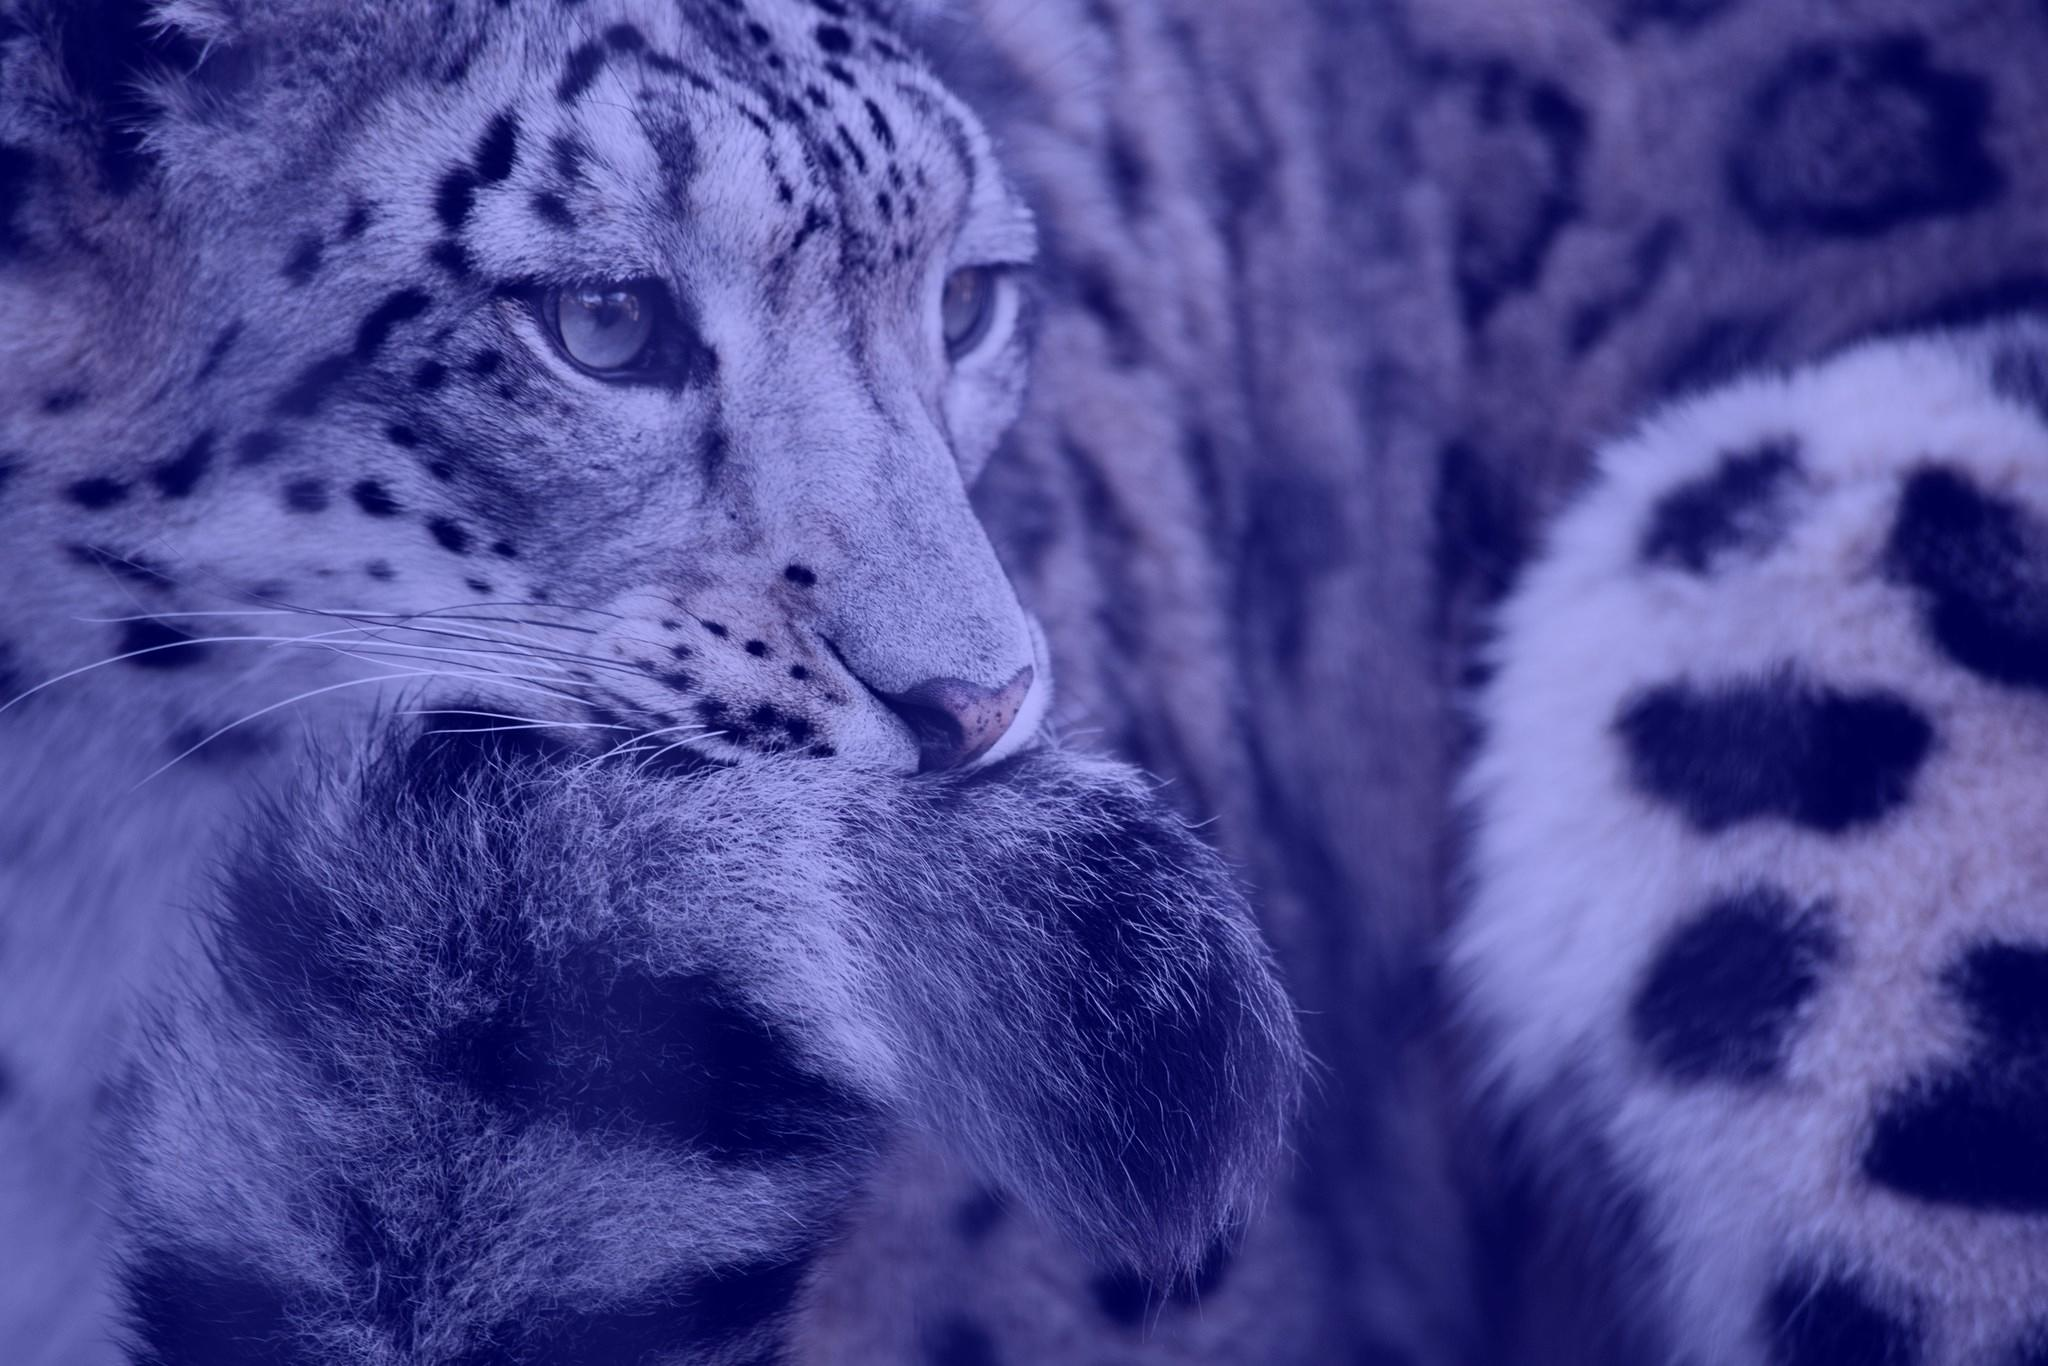

In [23]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)